In [19]:
import numpy as np
from matplotlib import pyplot as plt 
from numpy import genfromtxt
from sklearn.utils import shuffle
import csv
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [91]:
with open('21/1layer.csv', 'r') as f:
  reader = csv.reader(f)
  d = list(reader)
d = d[1:]
d = np.asarray(d, dtype=float)
onelayerdata = np.zeros((d.shape[0], d.shape[1]+2), dtype=float)
onelayerdata[:,:6]=d[:,:6]
onelayerdata[:,8:10]=d[:,6:9]
onelayerdata=onelayerdata[onelayerdata[:,0]==224]
print(onelayerdata.shape)
d=genfromtxt('21/2layer.csv', delimiter=',')
d=d[:,:-1]
twolayerdata=d
print(twolayerdata.shape)
d=genfromtxt('21/3layer.csv', delimiter=',')
d=d[:,:-1]
threelayerdata=d
print(threelayerdata.shape)

totaldata=np.concatenate((onelayerdata, twolayerdata, threelayerdata))
print(totaldata.shape)
f = totaldata[:,:8]
y = (totaldata[:,8])
print(f.shape)

f, y = shuffle(f,y)
trainf = f[:int(0.85*len(f))]
trainy = y[:int(0.85*len(f))]
testf = f[int(0.85*len(f)):]
testy = y[int(0.85*len(f)):]
print(trainf.shape, testf.shape, trainy.shape, testy.shape)

(85, 10)
(448, 10)
(5824, 10)
(6357, 10)
(6357, 8)
(5403, 8) (954, 8) (5403,) (954,)


In [92]:
class numpy2Dataset(Dataset):
  def __init__(self, features, values):
    self.features = features
    self.values = values
  def __len__(self): 
      return len(self.features)
  def __getitem__(self, i): 
      return self.features[i], self.values[i]

In [93]:
traintensor = numpy2Dataset(trainf, trainy)
trainloader = torch.utils.data.DataLoader(traintensor, batch_size=200)
testtensor = numpy2Dataset(testf, testy)
testloader = torch.utils.data.DataLoader(testtensor, batch_size=len(testtensor))

In [94]:
model = nn.Sequential(nn.Linear(8,400), nn.ReLU(inplace=True), nn.Linear(400,400), nn.ReLU(inplace=True), nn.Linear(400,100),nn.ReLU(inplace=True), nn.Linear(100,1))
model.float()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [95]:
def train():
    model.train()
    trainloss=0
    for data, target in trainloader:
        optimizer.zero_grad()
        output = model(data.float())
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        trainloss += loss.item()
    return trainloss

def test(): 
    model.eval()
    testloss=0
    for data, target in testloader:
        output = model(data.float())
        loss = criterion(output, target)
        testloss += loss.item()
    return testloss

In [96]:
num_epoch = 200
for epoch in range(num_epoch):
    train_loss=train()
    test_loss=test()
    if epoch % 50 ==0:
        print("Epoch: {} Train Squared Loss: {}".format(epoch, (train_loss)))
        print("Epoch: {} Test Squared Loss: {}".format(epoch, (test_loss)))
print("Test Loss: {}".format(np.sqrt(test())))

Epoch: 0 Train Loss: 3330152351744.0
Epoch: 0 Test Loss: 128128802816.0
Epoch: 50 Train Loss: 1921534101504.0
Epoch: 50 Test Loss: 77197631488.0
Epoch: 100 Train Loss: 1920524746752.0
Epoch: 100 Test Loss: 77199917056.0
Epoch: 150 Train Loss: 1919336005632.0
Epoch: 150 Test Loss: 77197754368.0
Test Loss: 77204070400.0


77204070400.0 277856.20453752694
277856.2


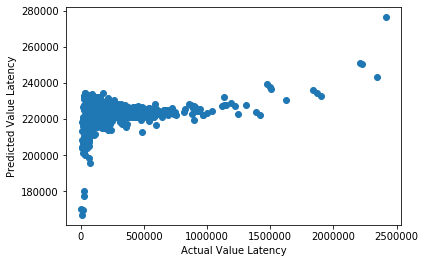

In [97]:
def pred(): 
    model.eval()
    for data, target in testloader:
        output = model(data.float())
        loss = criterion(output, target)
        print(loss.item(), np.sqrt(loss.item()))
    return target, output

truevalues, predicted = pred()
testy = truevalues.detach().numpy()
pred = predicted.detach().numpy()
print(np.sqrt(np.mean((testy-pred)**2)))
plt.xlabel("Actual Value Latency")
plt.ylabel("Predicted Value Latency")
plt.scatter(testy, pred)
plt.show()

In [98]:
from sklearn.neural_network import MLPRegressor
dnn21 = MLPRegressor(hidden_layer_sizes=(400,400,100))
dnn21.fit(trainf, trainy)
print(dnn21.score(testf, testy))
pred = dnn21.predict(testf)
print(np.sqrt(np.mean((testy-pred)**2)))

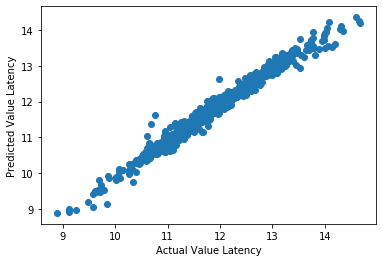

In [82]:
plt.xlabel("Actual Value Latency")
plt.ylabel("Predicted Value Latency")
plt.scatter(testy, pred)
plt.show()